Hunter Bennett  
Christopher K Glass Laboratory  
Created Oct 23 2017 | Last updated Nov 27 2017
_____

Map expression of lipid pathway genes across strains

#### Import packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image
import hbUtils
import subprocess
import os
import glob
import re
%matplotlib inline
%load_ext rpy2.ipython

#### SET WORKING DIRECTORIES  

In [ ]:
# Set analysis output directory and location of data on server.
outdir = "/home/h1bennet/scratch/171108_NASH_Strains/"
datapath = "/home/h1bennet/Kupffer/RNA/"
samples = ["aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A_JSSTDT_16_09_26",
            "aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3B_JSSTDT_16_09_26",
            "aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3c_JSS_TDT_16_09_28",
            "aj_KupfferTotal_RNA_polyA_ControlDiet_30week_AJ1c_JSS_TDT_16_09_28",
            "aj_KupfferTotal_RNA_polyA_ControlDiet_30week_AJ1d_JSS_TDT_16_09_28",
            "balbc_KupfferTotal_RNA_polyA_AMLNDiet_30week_Balb3a_JSS_TDT_16_09_28",
            "balbc_KupfferTotal_RNA_polyA_AMLNDiet_30week_Balb3B_JSSTDT_16_09_26",
            "balbc_KupfferTotal_RNA_polyA_AMLNDiet_30week_Balb3C_JSSTDT_16_09_26",
            "balbc_KupfferTotal_RNA_polyA_AMLNDiet_30week_Balb3d_JSS_TDT_16_09_28",
            "balbc_KupfferTotal_RNA_polyA_ControlDiet_30week_Balb1c_JSS_TDT_16_09_28",
            "balbc_KupfferTotal_RNA_polyA_ControlDiet_30week_Balb1d_JSS_TDT_16_09_28",
            "NCoRWT_KupfferTotal_RNA_polyA_AMLNDiet_30week_LN136C_JSS_TDT_16_09_19",
            "NCoRWT_KupfferTotal_RNA_polyA_AMLNDiet_30week_LN141A_JSS_TDT_16_09_21",
            "NCoRWT_KupfferTotal_RNA_polyA_ControlDiet_30week_LN134B_JSS_TDT_16_09_21",
            "NCoRWT_KupfferTotal_RNA_polyA_ControlDiet_30week_LN134C_JSS_TDT_16_09_19",
            "NCoRWT_KupfferTotal_RNA_polyA_ControlDiet_30week_LN134D_JSS_TDT_16_09_21"]
samplepaths = [datapath + '/' + s for s in samples]
group = [0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5]
batch = [0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 3, 3, 2, 3]
strains = [j.split('_')[0] for j in samples]

# Set up Data Frame
samplesDF = pd.DataFrame(samples, columns = ['Samples'])
samplesDF['samplepaths'] = samplepaths
samplesDF['group'] = group
samplesDF['batch'] = batch
samplesDF['strain'] = [j.replace('-', '_').split('_')[0].lower() for j in samplesDF.Samples]
samplesDF['diet'] = pd.Series(['AMLN' if 'AMLN' in name else 'Control' for name in samplesDF.Samples])
samplesDF['color'] = pd.Series(['b'] * len(samplesDF))
samplesDF.color.loc[(samplesDF.strain == 'aj') & (samplesDF.diet == 'Control')] = '#fb9a99'
samplesDF.color.loc[(samplesDF.strain == 'aj') & (samplesDF.diet == 'AMLN')] = '#e31a1c'
samplesDF.color.loc[(samplesDF.strain == 'balbc') & (samplesDF.diet == 'Control')] = '#a6cee3'
samplesDF.color.loc[(samplesDF.strain == 'balbc') & (samplesDF.diet == 'AMLN')] = '#1f78b4'
samplesDF.color.loc[(samplesDF.strain == 'ncorwt') & (samplesDF.diet == 'Control')] = '#b2df8a'
samplesDF.color.loc[(samplesDF.strain == 'ncorwt') & (samplesDF.diet == 'AMLN')] = '#33a02c'
samplesDF['group_label'] = samplesDF.strain + '-' + samplesDF.diet

#### Define Functions for Analysis

In [ ]:
def run_annotateRepeats(dirpaths, genome = 'mm10', countType = 'genes',
                        raw = False, print_out = False, norm = None):
    '''Python wrapper for analyzeRepeates.pl
    Right now a basic implementation, evnetually add more
    functionality for variables to be passed'''
    import subprocess
    aRCall = ['analyzeRepeats.pl', 'rna', genome, '-count', countType]
    if raw:
        aRCall.extend(['-raw'])
    elif norm !=None:
        aRCall.extend(['-' + norm])
    else:
        aRCall.extend(['-norm', '1e7'])
    aRCall.extend(['-d'])
    aRCall.extend(dirpaths)
    if print_out: print(aRCall)
    p = subprocess.Popen(aRCall, stdout = subprocess.PIPE, stderr = subprocess.PIPE)
    out, err = p.communicate()
    
    return out, err

def run_getDiffExpression(dirpaths, groups, batch = None, genome = 'mm10', countType = 'genes', print_out = False):
    '''Python wrapper for getDiffExpression.pl
    groups should be the experimental groups for analysis
    batch can be used to control for experimental date
    see documentation for getDiffExprssion.pl for more info
    
    eventually implement option to control the algorithm used'''
    import subprocess
    
    # Run annotate repeats with no adjustments
    out, err = run_annotateRepeats(dirpaths, countType = countType, raw = True)
    f = open(outdir + '/tmpARForgDE.txt', 'w')
    f.write(out.decode('utf-8'))
    f.close()
    
    # Run diff exp
    gDECall = ['getDiffExpression.pl', outdir + '/tmpARForgDE.txt']
    gDECall.extend(groups)
    # gDECall.extend(['-edgeR'])
    if batch is not None:
        gDECall.extend(['-batch'])
        gDECall.extend(batch)
    if print_out: print(gDECall)
    p = subprocess.Popen(gDECall, stdout = subprocess.PIPE, stderr = subprocess.PIPE)
    gDEOut, gDEErr = p.communicate()
    
    subprocess.call(['rm', outdir + '/tmpARForgDE.txt'])
    return gDEOut, gDEErr

def df_col_subset(x, id_str):
    '''Returns pandas dataframe with only columns containing id_str'''
    return x[x.columns[pd.Series(x.columns).str.contains(id_str)]]


In [ ]:
def pull_json_db(url):
    ''' pulls json db and returns it as a json object'''
    import requests, sys, json
    
    r = requests.get(url, headers={ "Accept" : "application/json"})

    if not r.ok:
        r.raise_for_status()
        sys.exit()

    return json.loads(r.text)

def pull_go_terms(term):
    ''' this function pulls go gene IDs from the QuickGo API
    interface. Currently simply pulls all genes directly associatd
    with the term and returns a list of the gene id, gene name, 
    associated organism, and gene product type

    plan to add filtering options to filter by animal (simple using the
    request url) AND add pulling from descendents (complicated)

    term is a string including the "GO:" OR a string without the GO: header OR an int
    without the GO header.
    '''

    # import req packages
    import requests, sys, json

    # clean input
    if type(term) == str:
        term = term.replace('GO:', '')

    if type(term) == int:
        term = str(term)

    requestURL = "https://www.ebi.ac.uk/QuickGO/services/geneproduct/search?query=GO%3A" + term + "&type=protein&limit=100"

    db = pull_json_db(requestURL)

    pagenum = db['pageInfo']['total']
    gene_list = [[x['id'], x['name'], x['taxonId'], x['type']] for x in db['results']]
    
    print(requestURL)
    print(term)
    if pagenum == 1:
        return gene_list
    
    else:
        for page in range(2, pagenum + 1): # want to start at the second page since we initialized
            db = pull_json_db(requestURL + '&page=' + str(pagenum))
            gene_list.extend([[x['id'], x['name'], x['taxonId'], x['type']] for x in db['results']])
    
    return gene_list

In [ ]:
pd.DataFrame(pull_go_terms('GO:0046890'))

In [ ]:
## CONSIDER IMPLEMENTATION OF -PC 3 or -PC 4?
# Run annotate repeats
out, err = run_annotateRepeats(samplepaths, countType = 'genes')
f = open(outdir + '/rnaseq_matrixGenes.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons with raw counts for DESeq
out, err = run_annotateRepeats(samplepaths, countType='genes', raw=True)
f = open(outdir + '/rnaseq_matrixGenesRaw.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons - rlog normalized for plotting
out, err = run_annotateRepeats(samplepaths, countType = 'genes', norm='rlog')
f = open(outdir + '/rnaseq_matrixGenes_rlog.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons - rpkm normalized for conversion to tpm
out, err = run_annotateRepeats(samplepaths, countType = 'genes', norm='rpkm')
f = open(outdir + '/rnaseq_matrixGenes_rpkm.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons
out, err = run_annotateRepeats(samplepaths, countType = 'exons')
f = open(outdir + '/rnaseq_matrixExons.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons with raw counts for DESeq
out, err = run_annotateRepeats(samplepaths, countType='exons', raw=True)
f = open(outdir + '/rnaseq_matrixExonsRaw.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons - rlog normalized for plotting
out, err = run_annotateRepeats(samplepaths, countType = 'exons', norm='rlog')
f = open(outdir + '/rnaseq_matrixExons_rlog.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

# Run annotate repeats for exons - rpkm normalized for conversion to tpm
out, err = run_annotateRepeats(samplepaths, countType = 'exons', norm='rpkm')
f = open(outdir + '/rnaseq_matrixExons_rpkm.txt', 'w')
f.write(out.decode('utf-8'))
f.close()

In [ ]:
pd.read_html("pd.read_html('http://amigo.geneontology.org/amigo/search/bioentity?q=*:*&fq=regulates_closure:%22GO:0010874%22&sfq=document_category:%22bioentity%22")

### PCA Analysis of the Data

In [ ]:
# import rpkm counts as output by annotateRepeats
rpkm = pd.read_csv(outdir + '/rnaseq_matrixExons_rpkm.txt', sep='\t')

# Create column for gene
rpkm['Gene'] = pd.Series([x.split('|')[0] for x in rpkm['Annotation/Divergence']])

# clean up the columns a bit
pattern = r"\s+\(.+\)$"
rpkm.columns = pd.Series(rpkm.columns)\
        .str.replace(pattern, '')\
        .str.split('/')\
        .str[-1]
        
#subset matrix of only counts
rpkm_mat = rpkm.set_index('RepeatID')[rpkm.columns[
        rpkm.columns.to_series().str.contains('RNA')]]

# create tpm matrix
tpm_mat = rpkm_mat.apply(lambda x: x * (10**6)/x.sum())

In [ ]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

# want to run the algorithms on standard scaled data
# mean = 0, variance = 1
tpm_std = StandardScaler().fit_transform(tpm_mat) # scale data
pca = PCA(n_components=2)
tpm_pca = pca.fit_transform(tpm_std.T)

# Plot Results
pca_order = ['balbc-Control', 'balbc-AMLN', 'ncorwt-Control',
             'ncorwt-AMLN', 'aj-Control', 'aj-AMLN']

tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2'],
        index=samplesDF.group_label).reset_index()
with sns.color_palette('Paired'):
    sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
               hue='group_label', hue_order = pca_order)

### Cluster-map analysis

In [ ]:
from scipy.spatial import distance
tpm_dist = pd.DataFrame(distance.squareform(distance.pdist(tpm_std.T, 'euclidean')),
                        columns = list(samplesDF.group_label),
                        index = list(samplesDF.group_label))
g = sns.clustermap(tpm_dist, cmap=sns.color_palette("Blues_r"))

### Run DESeq2 using R Magic

Prep data for importing into R

In [40]:
# import the raw count file
counts_df = pd.read_csv(outdir + '/rnaseq_matrixExonsRaw.txt', sep='\t')

# create gene name column
counts_df['Gene'] = pd.Series([x.split('|')[0] for x in counts_df['Annotation/Divergence']])

# clean up the columns a bit
pattern = r"\s+\(.+\)$"
counts_df.columns = pd.Series(counts_df.columns).str.replace(pattern, '')\
        .str.split('/')\
        .str[-1]
counts_df = counts_df.set_index('Transcript/RepeatID')

# Count matrix for DESeq where columns are samples, rows are geneIDs and
# data is raw counts
counts_mat = counts_df[counts_df.columns[
        pd.Series(counts_df.columns).str.contains('aj|balb|NCor',
                flags=re.IGNORECASE)]]
counts_mat.to_csv(outdir + '/rnaseq_matrixExonsRaw_countmat_forDESeq.txt')

# Column Data Information for DESeq
col_data = samplesDF[['Samples', 'strain', 'diet']]
col_data = col_data.set_index('Samples')
col_data.to_csv(outdir + '/rnaseq_matrixExonsRaw_colData_forDESeq.txt')

In [94]:
%%R -i counts_mat,col_data
# load DESeq
library("DESeq2")
#create DESeq2 object
dds <- DESeqDataSetFromMatrix(countData = counts_mat,
                             colData = col_data,
                             design = ~ strain + diet + strain:diet)

# adjust factors to ensure that we are comparing AMLN to control
dds$diet <- factor(dds$diet, levels = c('Control', 'AMLN'))
dds$strain <- factor(dds$strain, levels = c('ncorwt', 'balbc', 'aj'))


# run DESeq LRT to assess effect of strains on diet
dds <- DESeq(dds, test="LRT", reduced=~diet)
res <- results(dds, alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file="lrt_strainsdiet_vs_diet_DESeq2_results.txt")

# run DESeq LRT to assess effect of strains on diet
dds <- DESeq(dds, test="LRT", reduced=~strain)
res <- results(dds, alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file="lrt_strainsdiet_vs_strains_DESeq2_results.txt")

# run DESeq with full model
dds <- DESeq(dds)

# diet effect for ncorwt
res <- results(dds, contrast=c('diet', 'AMLN', 'Control'), alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file="ncorwt_AMLN_DESeq2_results.txt")

# diet effect for balbc
res <- results(dds, contrast=list( c('diet_AMLN_vs_Control','strainbalbc.dietAMLN') ), alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file="balbc_AMLN_DESeq2_results.txt", sep='\t')

# diet effect for aj
res <- results(dds, contrast=list( c('diet_AMLN_vs_Control','strainaj.dietAMLN') ), alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file="aj_AMLN_DESeq2_results.txt")

# interaction term for condition effect between balbc and ncorwt
res <- results(dds, name='strainbalbc.dietAMLN', alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file="balbc_ncorwt_AMLN_interaction_DESeq2_results.txt")

# interaction term for condition effect between aj and ncorwt
res <- results(dds, name='strainaj.dietAMLN', alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file="aj_ncorwt_AMLN_interaction_DESeq2_results.txt")

# interaction term for condition effect between balbc and aj
res <- results(dds, contrast=list("strainbalbc.dietAMLN", "strainaj.dietAMLN"), alpha = 0.05)
head(res)
res_ordered <- res[order(res$padj), ]
write.csv(as.data.frame(res_ordered), 
          file="balbc_aj_AMLN_interaction_DESeq2_results.txt")

### Start with an overall description of the data
note from DESeq2 documentation that the following transcript criteria
result in p values being set to NA
* all samples have zero counts (baseMean=0, all else NA)
* extreme outlier count value (pvalue, padj are NA)
* row filtered out by automatic independent filtering (low mean normalized count) (padj=NA)


In [7]:
ncorwt_amln = pd.read_csv(outdir + 'ncorwt_AMLN_DESeq2_results.txt', sep=',', index_col=0)
aj_amln = pd.read_csv(outdir + 'aj_AMLN_DESeq2_results.txt', sep=',', index_col=0)
balbc_amln = pd.read_csv(outdir + 'balbc_AMLN_DESeq2_results.txt', sep=',', index_col=0)
balbc_ncorwt = pd.read_csv(outdir + 'balbc_ncorwt_AMLN_interaction_DESeq2_results.txt', sep=',', index_col=0)
balbc_aj = pd.read_csv(outdir + 'balbc_aj_AMLN_interaction_DESeq2_results.txt', sep=',', index_col=0)
aj_ncorwt = pd.read_csv(outdir + 'aj_ncorwt_AMLN_interaction_DESeq2_results.txt', sep=',', index_col=0)
lrt_strainfx = pd.read_csv(outdir + 'lrt_strainsdiet_vs_diet_DESeq2_results.txt', sep=',', index_col=0)
lrt_dietfx = pd.read_csv(outdir + 'lrt_strainsdiet_vs_strains_DESeq2_results.txt', sep=',', index_col=0)

### Comparing AMLN diet mice

In [16]:
# How many differentially regulated genes are shared?
ncorwt_p05 = list(ncorwt_amln.index[ncorwt_amln.padj <= 0.05])
ncorwt_fc2_up = list(ncorwt_amln.index[ncorwt_amln.log2FoldChange >= np.log2(2)])
ncorwt_fc2_dn = list(ncorwt_amln.index[ncorwt_amln.log2FoldChange <= -np.log2(2)])
aj_p05 = list(aj_amln.index[aj_amln.padj <= 0.05])
aj_fc2_up = list(aj_amln.index[aj_amln.log2FoldChange >= np.log2(2)])
aj_fc2_dn = list(aj_amln.index[aj_amln.log2FoldChange <= -np.log2(2)])
balbc_p05 = list(ncorwt_amln.index[ncorwt_amln.padj <= 0.05])
balbc_fc2_up = list(ncorwt_amln.index[ncorwt_amln.log2FoldChange >= np.log2(2)])
balbc_fc2_dn = list(ncorwt_amln.index[ncorwt_amln.log2FoldChange <= -np.log2(2)])

In [23]:
# set fc and p value of interest
fc = 2
p = 0.05

# create dict of analyses to iterate over
analysis_dict = {'ncorwt_amln': ncorwt_amln, 'aj_amln': aj_amln,
                'balbc_amln': balbc_amln, 'balbc_ncorwt': balbc_ncorwt,
                'balbc_aj': balbc_aj, 'aj_ncorwt': aj_ncorwt,
                'lrt_strainfx': lrt_strainfx, 'lrt_dietfx': lrt_dietfx}
dkeys = list(analysis_dict.keys())

# data frames to store the results
p05_overlap = pd.DataFrame(np.zeros((len(analysis_dict), len(analysis_dict))),
                           columns = dkeys, index = dkeys)
up_overlap = pd.DataFrame(np.zeros((len(analysis_dict), len(analysis_dict))),
                           columns = dkeys, index = dkeys)
dn_overlap = pd.DataFrame(np.zeros((len(analysis_dict), len(analysis_dict))),
                           columns = dkeys, index = dkeys)
sig_summ = []
p05_sets = []
up_sets = []
dn_sets = []

def intersect(a, b):
    return list(set(a) & set(b))

for label, data in analysis_dict.items():
    
    # find transcripts of interest
    p05 = list(data.index[data.padj <= 0.05])
    up = list(data.index[(data.log2FoldChange >= np.log2(2)) & (data.padj <= 0.05)])
    dn = list(data.index[(data.log2FoldChange <= -np.log2(2)) & (data.padj <= 0.05)])
    
    # outliers and filtered genes defined as above
    outliers = ((~(data.baseMean == 0)) & (data.padj.isnull()) & (data.pvalue.isnull()))
    filtered = ((~(data.baseMean == 0)) & (data.padj.isnull()) & (data.pvalue.notnull()))
    
    # save summary of total transcripts meeting certain criteria
    sig_summ.append({'n_transcripts': len(data),
                  'sig_padj_05': (data.padj <= 0.05).sum(),
                  'zero_counts': (data.baseMean == 0).sum(),
                  'outliers': outliers.sum(),
                  'filtered': filtered.sum()})
    p05_sets.append({label: p05})
    up_sets.append({label: up})
    dn_sets.append({label: dn})
    
    # iterate again so we can find intersect
    for label2, data2 in analysis_dict.items():
        p05_2 = list(data2.index[data2.padj <= 0.05])
        up_2 = list(data2.index[(data2.log2FoldChange >= np.log2(2)) & (data2.padj <= 0.05)])
        dn_2 = list(data2.index[(data2.log2FoldChange <= -np.log2(2)) & (data2.padj <= 0.05)])
        
        # get overlap between lists 1 and 2
        p05_overlap.loc[label, label2] = len(intersect(p05, p05_2))
        up_overlap.loc[label, label2] = len(intersect(up, up_2))
        dn_overlap.loc[label, label2] = len(intersect(dn, dn_2))

# calculate total fc overalp
fc_overlap = dn_overlap.add(up_overlap)

In [18]:
pd.DataFrame(sig_summ, index = dkeys)

,filtered,n_transcripts,outliers,sig_padj_05,zero_counts
ncorwt_amln,5751,35745,38,638,5780
aj_amln,5751,35745,38,81,5780
balbc_amln,6326,35745,38,75,5780
balbc_ncorwt,6900,35745,38,136,5780
balbc_aj,0,35745,38,0,5780
aj_ncorwt,5751,35745,38,30,5780
lrt_strainfx,4026,35745,38,6430,5780
lrt_dietfx,6326,35745,38,798,5780


Venn Diagrams describing overlap

In [20]:
fc_overlap 

,ncorwt_amln,aj_amln,balbc_amln,balbc_ncorwt,balbc_aj,aj_ncorwt,lrt_strainfx,lrt_dietfx
ncorwt_amln,546.0,19.0,5.0,0.0,0.0,0.0,0.0,2.0
aj_amln,19.0,77.0,11.0,5.0,0.0,1.0,51.0,54.0
balbc_amln,5.0,11.0,65.0,17.0,0.0,0.0,24.0,26.0
balbc_ncorwt,0.0,5.0,17.0,131.0,0.0,18.0,93.0,89.0
balbc_aj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aj_ncorwt,0.0,1.0,0.0,18.0,0.0,25.0,25.0,25.0
lrt_strainfx,0.0,51.0,24.0,93.0,0.0,25.0,1936.0,354.0
lrt_dietfx,2.0,54.0,26.0,89.0,0.0,25.0,354.0,392.0


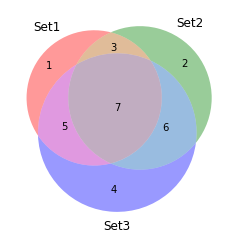

In [21]:
import matplotlib_venn
matplotlib_venn.venn3(subsets = (546, 19, , 4, 5, 6, 7), set_labels = ('Set1', 'Set2', 'Set3'))


Run GSEA for all Comparisons

In [355]:
gene_id_match = rpkm.loc[:, ['RepeatID', 'Gene']].set_index('RepeatID')
gene_id_match.loc['NM_178759']

Gene    TIMD4
Name: NM_178759, dtype: object

In [366]:
fc = 2 # Set fc cutoff

for label, data in analysis_dict.items():
    
    genes_up = (data.padj <= 0.05) & (data.log2FoldChange >= np.log2(fc))
    dg_up = gene_id_match.Gene[genes_up].tolist()
    
    genes_dn = (data.padj <= 0.05) & (data.log2FoldChange <= -np.log2(fc))
    dg_dn = gene_id_match.Gene[genes_dn].tolist()
    
    if len(dg_up) > 0:
        # Run upregulated gene analysis
        enr_up = gp.enrichr(gene_list=dg_up, description = label + '_' + str(fc) + '_fold_upreg',
            gene_sets='KEGG_2016',
            cutoff=0.5, outdir = outdir + '/Enrichr')
        # print results
        print('Analyzing ' + label + ' for enriched pathways...')
        if (enr_up.res2d['Adjusted P-value'] < 0.05).any():
            print(' '.join([label, str(fc), 'Fold Upregulated Gene Pathways']))
            print(enr_up.res2d[enr_up.res2d['Adjusted P-value'] <= 0.05].head(10))
    else: print('No upreg genes found for ' + label)
    
    if len(dg_dn) > 0:
        # Run down gene analysis
        enr_dn = gp.enrichr(gene_list=dg_dn, description = label + '_' + str(fc) + '_fold_downreg',
            gene_sets='KEGG_2016',
            cutoff=0.5, outdir = outdir + '/Enrichr')
    
        #print results
        if (enr_dn.res2d['Adjusted P-value'] < 0.05).any():
            print(' '.join([label, str(fc), 'Fold Downregulated Gene Pathways']))
            print(enr_dn.res2d[enr_dn.res2d['Adjusted P-value'] <= 0.05].head(10))
    else: print('No downreg genes found for ' + label)


Analyzing ncorwt_amln for enriched pathways...
ncorwt_amln 2 Fold Upregulated Gene Pathways
                                                Term Overlap   P-value  \
0   Cardiac muscle contraction_Homo sapiens_hsa04260    5/78  0.000430   
1  Hypertrophic cardiomyopathy (HCM)_Homo sapiens...    5/83  0.000572   
2       Dilated cardiomyopathy_Homo sapiens_hsa05414    5/90  0.000827   
3     ECM-receptor interaction_Homo sapiens_hsa04512    5/82  0.000541   
4               Focal adhesion_Homo sapiens_hsa04510   7/202  0.001318   
5  Protein digestion and absorption_Homo sapiens_...    5/90  0.000827   

   Adjusted P-value  Old P-value  Old Adjusted P-value   Z-score  \
0          0.021349     0.000873               0.04136 -1.797870   
1          0.021349     0.001138               0.04136 -1.784970   
2          0.021349     0.001603               0.04136 -1.805957   
3          0.021349     0.001081               0.04136 -1.682142   
4          0.028336     0.002646               0.

### Comparison Specific Plots

Start by looking at ncorwt_amln (AMLN diet compared to control diet)

In [248]:
n_transcripts =  ncorwt_amln.shape[0]
p_05 = (ncorwt_amln.padj <= 0.05)
zero_cts = (ncorwt_amln.baseMean == 0)
outliers = ( (~zero_cts) & (ncorwt_amln.padj.isnull()) & (ncorwt_amln.pvalue.isnull()) )
filtered = ( (~zero_cts) & (ncorwt_amln.padj.isnull()) & (ncorwt_amln.pvalue.notnull()) )

print(str(n_transcripts) + ' total transcripts')
print(str(p_05.value_counts()[1]) + ' sig at padj < 0.05')
print(str(zero_cts.value_counts()[1]) + ' transcripts with zero counts')
print(str(outliers.value_counts()[1]) + ' transcripts w/ outliers')
print(str(filtered.value_counts()[1]) + ' transcripts w/ low automatic independent filtering')

35745 total transcripts
638 sig at padj < 0.05
5780 transcripts with zero counts
38 transcripts w/ outliers
5751 transcripts w/ low automatic independent filtering


Create MA Plot

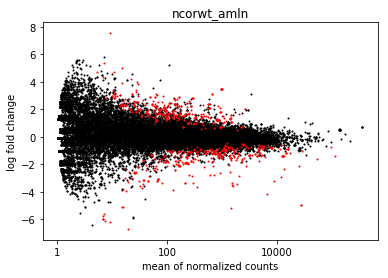

In [79]:
ncorwt_amln['log10BaseMean'] = np.log10(ncorwt_amln.baseMean + 1)
fig, ax = plt.subplots()
# plot nonsig in black
plt.scatter(ncorwt_amln.log10BaseMean[~p_05],
            ncorwt_amln.log2FoldChange[~p_05],
           c='k', s=1, label='padj < 0.05')

# plot sig in red
plt.scatter(ncorwt_amln.log10BaseMean[p_05],
            ncorwt_amln.log2FoldChange[p_05],
           c='r', s=1, label='padj < 0.05')

# plt.scatter(ncorwt_amln.log10BaseMean, ncorwt_amln.log2FoldChange)
ticks = ax.set_xticks([0, 2, 4])
labels = ax.set_xticklabels(['1', '100', '10000'])
ax.set_xlabel('mean of normalized counts')
ax.set_ylabel('log fold change')
ax.set_title('ncorwt_amln')

Run Basic Enrichment Analysis with EnrichR

In [251]:
ncorwt_amln_merge = ncorwt_amln.merge(rpkm,
        how='left', left_index=True, right_on='RepeatID')

In [259]:
import gseapy as gp
fc = 2
p = 0.05
up = ncorwt_amln_merge.Gene[(ncorwt_amln_merge.padj <= p) & (
        ncorwt_amln_merge.log2FoldChange >= np.log2(fc))]
dn = ncorwt_amln_merge.Gene[(ncorwt_amln_merge.padj <= p) & (
        ncorwt_amln_merge.log2FoldChange <= -np.log2(fc))]

enr_up = gp.enrichr(gene_list=list(up), description='ncorwt_amln_fc2Up_padg05_KEGG', gene_sets='KEGG_2016',
               outdir=outdir + '/Enrichr/', cutoff=0.05, format='png')

enr_dn = gp.enrichr(gene_list=list(dn), description='ncorwt_amln_fc2Up_padg05_KEGG', gene_sets='KEGG_2016',
               outdir=outdir + '/Enrichr/', cutoff=0.05, format='png')

In [18]:
rnaplt = rpkm.melt(
    id_vars = ['RepeatID', 'Divergence', 'Gene'],
    value_vars = rpkm.columns[rpkm.columns.to_series().str.contains('FPKM')],
    var_name = 'Sample', value_name = 'rpkm'
)

In [10]:
rpkm.head()

,RepeatID,chr,start,end,strand,Length,Copies,Divergence,aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A_JSSTDT_16_09_26 FPKM,aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3B_JSSTDT_16_09_26 FPKM,...,balbc_KupfferTotal_RNA_polyA_AMLNDiet_30week_Balb3C_JSSTDT_16_09_26 FPKM,balbc_KupfferTotal_RNA_polyA_AMLNDiet_30week_Balb3d_JSS_TDT_16_09_28 FPKM,balbc_KupfferTotal_RNA_polyA_ControlDiet_30week_Balb1c_JSS_TDT_16_09_28 FPKM,balbc_KupfferTotal_RNA_polyA_ControlDiet_30week_Balb1d_JSS_TDT_16_09_28 FPKM,NCoRWT_KupfferTotal_RNA_polyA_AMLNDiet_30week_LN136C_JSS_TDT_16_09_19 FPKM,NCoRWT_KupfferTotal_RNA_polyA_AMLNDiet_30week_LN141A_JSS_TDT_16_09_21 FPKM,NCoRWT_KupfferTotal_RNA_polyA_ControlDiet_30week_LN134B_JSS_TDT_16_09_21 FPKM,NCoRWT_KupfferTotal_RNA_polyA_ControlDiet_30week_LN134C_JSS_TDT_16_09_19 FPKM,NCoRWT_KupfferTotal_RNA_polyA_ControlDiet_30week_LN134D_JSS_TDT_16_09_21 FPKM,Gene
0,NM_001329047,chr12,59095800,59190175,+,4538.0,1,Mia2|Ctage5|D12Bwg0579e|Mea6|Mgea|Mgea6|-|12 2...,33.408,30.155,...,27.665,25.890,14.558,18.336,15.132,17.195,18.030,19.304,13.899,Mia2
1,NM_172405,chr5,100804802,100820935,-,2488.0,1,Fam175a|3830405G04Rik|5630400M01Rik|AI506069|A...,1.554,1.752,...,1.849,1.543,1.109,1.476,1.062,1.451,1.190,1.658,1.720,Fam175a
2,NM_001168290,chr8,70234226,70261044,+,4089.0,1,Sugp2|Sfrs14|Srsf14|mKIAA0365|-|8|8 B3.3|prote...,5.053,5.432,...,4.297,6.116,5.492,5.570,5.014,5.561,5.177,6.593,5.292,Sugp2
3,NM_001166375,chr8,66386301,66471637,+,3936.0,1,March1|2900024D24Rik|BB085186|-|8|8 B3.1|prote...,62.138,56.246,...,44.855,33.405,25.226,22.942,30.057,21.672,29.580,30.197,28.219,March1
4,NM_178061,chr4,34949074,35157484,-,6024.0,1,Mob3b|8430436F23Rik|A430018A01Rik|Mobkl2b|-|4 ...,1.360,1.212,...,1.870,1.510,1.199,1.343,0.614,0.883,0.646,1.332,0.831,Mob3b


In [30]:
rnaplt = rpkm.melt(
    id_vars = ['RepeatID', 'Divergence', 'Gene'],
    value_vars = rpkm.columns[rpkm.columns.to_series().str.contains('FPKM')],
    var_name = 'Sample', value_name = 'rpkm'
)
# rnaplt.Sample = rnaplt.Sample.str.split('', 1).str[0]
rnaplt = pd.merge(rnaplt, samplesDF.loc[:, ('Samples', 'strain', 'diet')],
          left_on='Sample', right_on='Samples').drop('Samples', axis=1)

,RepeatID,Divergence,Gene,Sample,rpkm,strain,diet


In [24]:
rnaplt.Sample

0         aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
1         aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
2         aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
3         aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
4         aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
5         aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
6         aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
7         aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
8         aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
9         aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
10        aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
11        aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
12        aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
13        aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
14        aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
15        aj_KupfferTotal_RNA_polyA_AMLNDiet_30week_AJ3A...
16        aj_KupfferTotal_RNA_polyA_AMLN

In [14]:
h = sns.FacetGrid(rnaplt[rnaplt['Gene'].str.match('|'.join(['NR1H3$', 'NR1H2$']), flags=re.IGNORECASE)],
                  col="Gene", col_wrap=4, sharey = False, sharex = False)
h.map(sns.stripplot, 'strain', 'rpkm', 'diet', jitter = True,
      dodge=True, palette=sns.color_palette('deep', 2),
      hue_order=['Control', 'AMLN'])
h.add_legend()

ValueError: num must be 1 <= num <= 0, not 1

attempt to run GO enrichment with HOMER... hard to get entrez ids

In [191]:
pd.Series(ncorwt_amln[p_05 & lfc_2 & up].index)\
    .to_csv(outdir + 'GO/tmp_gene_list.txt')

In [198]:
fGCall = ['findGO.pl', outdir + 'GO/tmp_gene_list.txt',
 'mouse', outdir + '/GO/ncorwt_amln_p05_fc2_findGO/']

In [199]:
' '.join(fGCall)

'findGO.pl /home/h1bennet/scratch/171108_NASH_Strains/GO/tmp_gene_list.txt mouse /home/h1bennet/scratch/171108_NASH_Strains//GO/ncorwt_amln_p05_fc2_findGO/'

In [200]:
p =  subprocess.Popen(fGCall,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
out, err = p.communicate()

Attempt to run gsea using gseapy...

In [168]:
class_vector = list(pd.Series(ncorwt_tpm_mat.columns)\
                    .str.findall(diet_pattern)\
                    .str[0].dropna())
class_vector

['AMLN', 'AMLN', 'Control', 'Control', 'Control']

In [169]:
import gseapy as gp
#subset matrix of only counts
rpkm['Gene'] = rpkm['Gene'].str.upper()
rpkm_mat = rpkm.set_index('Gene')[rpkm.columns[
        rpkm.columns.to_series().str.contains('RNA')]]

# create tpm matrix
tpm_mat = rpkm_mat.apply(lambda x: x * (10**6)/x.sum())

ncorwt_tpm_mat = tpm_mat.loc[:, tpm_mat.columns[
        pd.Series(tpm_mat.columns).str.contains('NCoRWT')]]
ncorwt_tpm_mat.index.rename('NAME', inplace=True)
ncorwt_tpm_mat.reset_index(inplace=True)
diet_pattern = r'_(\D{4,7})Diet_'
class_vector = list(pd.Series(ncorwt_tpm_mat.columns)\
                    .str.findall(diet_pattern)\
                    .str[0].dropna())

ncorwt_tpm_mat

gs_res = gp.gsea(data=ncorwt_tpm_mat, gene_sets='KEGG_2016',
                cls=class_vector, permutation_type='phenotype',
                outdir = outdir + '/Enrichr', method='signal_to_noise',
                format='png')

KeyboardInterrupt: 

In [6]:
pcols = rna_adjp_fc.columns[rna_adjp_fc.columns.to_series()\
                            .str.contains('adj. p-value')]

comps = pcols.to_series().str.split('adj.')\
    .str[0]\
    .str.strip()\
    .tolist()

NameError: name 'rna_adjp_fc' is not defined

In [67]:
fc = 2 # Set fc cutoff
for comp in comps:
    genes_up = (rna_adjp_fc.loc[:, ' '.join([comp, 'adj. p-value'])] <= 0.05) & (
        rna_adjp_fc.loc[:,' '.join([comp, 'Log2 Fold Change'])] >= np.log2(fc))
    dg_up = rna_adjp['Gene'][genes_up].tolist()
    
    genes_dn = (rna_adjp_fc.loc[:, ' '.join([comp, 'adj. p-value'])] <= 0.05) & (
        rna_adjp_fc.loc[:,' '.join([comp, 'Log2 Fold Change'])] <= -np.log2(fc))
    dg_dn = rna_adjp['Gene'][genes_dn].tolist()
    
    # Run upregulated gene analysis
    enr_up = gp.enrichr(gene_list=dg_up, description = comp + '_' + str(fc) + '_fold_upreg',
        gene_sets='GO_Biological_Process_2017b',
        cutoff=0.5, outdir = outdir + '/Enrichr')
    
    # Run down gene analysis
    enr_dn = gp.enrichr(gene_list=dg_dn, description = comp + '_' + str(fc) + '_fold_downreg',
        gene_sets='GO_Biological_Process_2017b',
        cutoff=0.5, outdir = outdir + '/Enrichr')
    
        # print results
    print('Analyzing ' + comp + ' for enriched pathways...')
    if (enr_up.res2d['Adjusted P-value'] < 0.05).any():
        print(' '.join([comp, str(fc), 'Fold Upregulated Gene Pathways']))
        print(enr_up.res2d[enr_up.res2d['Adjusted P-value'] <= 0.05].head(10))
    if (enr_dn.res2d['Adjusted P-value'] < 0.05).any():
        print(' '.join([comp, str(fc), 'Fold Downregulated Gene Pathways']))
        print(enr_dn.res2d[enr_dn.res2d['Adjusted P-value'] <= 0.05].head(10))


2017-11-07 15:34:12,563 Warning: No enrich terms using library GO_Biological_Process_2017b when cuttoff = 0.5


Analyzing aj_AMLN vs. balbc_AMLN for enriched pathways...
aj_AMLN vs. balbc_AMLN 2 Fold Downregulated Gene Pathways
                                                Term Overlap       P-value  \
0  chemokine (C-X-C motif) ligand 12 signaling pa...    8/49  9.294523e-09   
1      C-C chemokine receptor CCR4 signaling pathway    8/49  9.294523e-09   
2      C-C chemokine receptor CCR7 signaling pathway    8/49  9.294523e-09   
3  chemokine (C-C motif) ligand 19 signaling pathway    8/49  9.294523e-09   
4   C-X-C chemokine receptor CXCR4 signaling pathway    8/49  9.294523e-09   
5  chemokine (C-C motif) ligand 21 signaling pathway    8/49  9.294523e-09   
6   chemokine (C-C motif) ligand 5 signaling pathway    8/49  9.294523e-09   
7   chemokine (C-C motif) ligand 2 signaling pathway    8/49  9.294523e-09   
8      C-C chemokine receptor CCR2 signaling pathway    8/49  9.294523e-09   
9          thrombopoietin-mediated signaling pathway    8/51  1.293089e-08   

   Adjusted P-value   Old